device: cpu
test dataset: (25600, 2) 

sequential_model(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


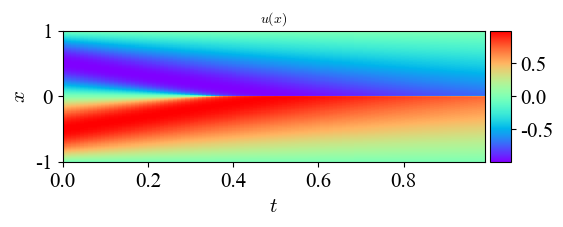

<AxesSubplot: title={'center': '$u(x)$'}, xlabel='$t$', ylabel='$x$'>

In [1]:
import numpy as np
import torch

from ViscousBurgersExact import burgers_gt
from visualization import *
from main import *
from used_attacks import regression_PGD

''' Settings and seeds '''

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("device:", device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
''' test dataset '''

x = np.linspace(-1, 1, 256)
t = np.linspace(0, .99, 100)
X, T = np.meshgrid(x,t)
U_gt = burgers_gt(t*np.pi)

x_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_test = U_gt.flatten('F')[:,None]
print("test dataset:", x_test.shape, '\n')

''' model '''

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = sequential_model(layers, device)
PINN.to(device)
print(PINN)
plot_u(U_gt, x, t, title="$u(x)$")

In [2]:
def generate_attack_samples(model, device, x_train, N0, n_samples=1000, \
    lb=[-1,0], ub=[1,1], steps=20, eps=1e-1, eta=2e-2, m=1):
    
    attack = regression_PGD(model, lb=lb, ub=ub, steps=steps, eps=eps, eta=eta)
    x_adv = attack.attack(x_train).cpu().detach().numpy()
    
    if x_adv.shape[0] > N0 + (m+1)*n_samples:
        x_adv = np.vstack([x_adv[:N0,:] ,x_adv[-(m+1)*n_samples:,:]])

    f_adv_pred = np.abs(model.function(x_adv).squeeze().cpu().detach().numpy())
    index = np.argsort(f_adv_pred)[::-1][:n_samples]
    x_adv = x_adv[index,:]
    f_adv_pred = f_adv_pred[index]
    
    plot_samples(x_adv, f_adv_pred)
    
    return x_adv


def retrain(model, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=1e5):
    
    x_train_temp = np.vstack([x_train, x_adv])
    
    f_test_pred = np.abs(model.function(x_test).squeeze().cpu().detach().numpy())
    plot_u(f_test_pred.reshape(X.shape).T, x, t, log=True, title="test $r(x;theta)$")

    model.iter = 0
    optimizer = torch.optim.Adam(PINN.parameters(), lr=0.0001)
    model.train_model_adam(optimizer, x_boundary, u_boundary, x_train_temp, epoch)
                           
    rmse, u_pred = model.test(x_test, u_test)
    print('Test RMSE: %.5f'  % (rmse))
                           
    plot_u_x(u_pred.reshape(X.shape).T, U_gt, x, t)
    plot_u(np.abs(u_pred.reshape(X.shape).T-U_gt), x, t, log=True, title="$|u(x;theta)-u(x)|$")

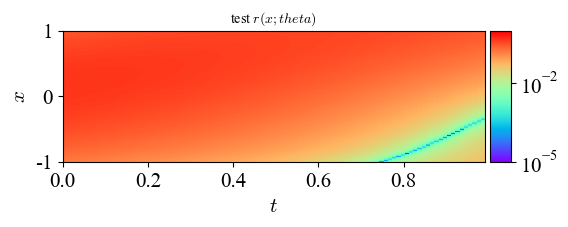

1000 tensor(0.0881, grad_fn=<AddBackward0>)
2000 tensor(0.0564, grad_fn=<AddBackward0>)
3000 tensor(0.0339, grad_fn=<AddBackward0>)
4000 tensor(0.0225, grad_fn=<AddBackward0>)
5000 tensor(0.0182, grad_fn=<AddBackward0>)
6000 tensor(0.0162, grad_fn=<AddBackward0>)
7000 tensor(0.0149, grad_fn=<AddBackward0>)
8000 tensor(0.0144, grad_fn=<AddBackward0>)
9000 tensor(0.0139, grad_fn=<AddBackward0>)
10000 tensor(0.0136, grad_fn=<AddBackward0>)
11000 tensor(0.0134, grad_fn=<AddBackward0>)
12000 tensor(0.0131, grad_fn=<AddBackward0>)
13000 tensor(0.0128, grad_fn=<AddBackward0>)
14000 tensor(0.0123, grad_fn=<AddBackward0>)
15000 tensor(0.0125, grad_fn=<AddBackward0>)
16000 tensor(0.0117, grad_fn=<AddBackward0>)
17000 tensor(0.0114, grad_fn=<AddBackward0>)
18000 tensor(0.0108, grad_fn=<AddBackward0>)
19000 tensor(0.0105, grad_fn=<AddBackward0>)
20000 tensor(0.0102, grad_fn=<AddBackward0>)
21000 tensor(0.0083, grad_fn=<AddBackward0>)
22000 tensor(0.0077, grad_fn=<AddBackward0>)
23000 tensor(0.0072

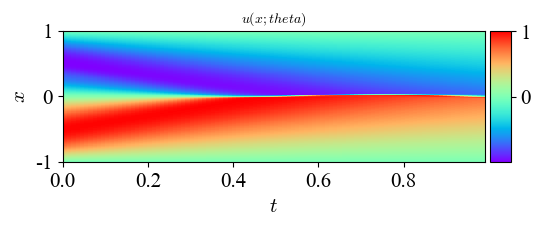

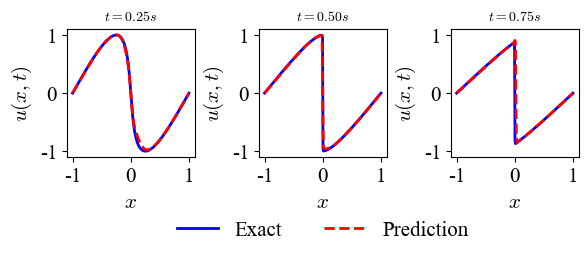

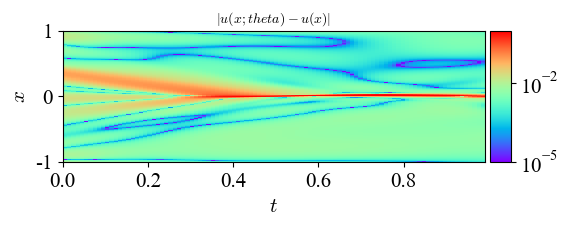

In [3]:
''' k=0 '''
N0 = 500
x_train, x_boundary, u_boundary = training_data_latin_hypercube(X, T, U_gt, N_inner=N0)
retrain(PINN, x_train, np.array([]).reshape((0,2)), \
    x_boundary, u_boundary, x_test, u_test, U_gt, epoch=1e5)


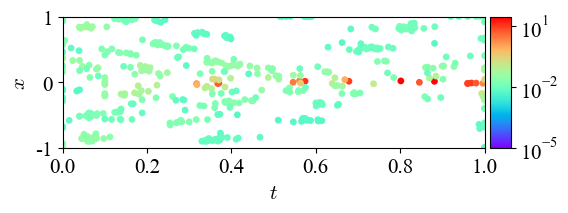

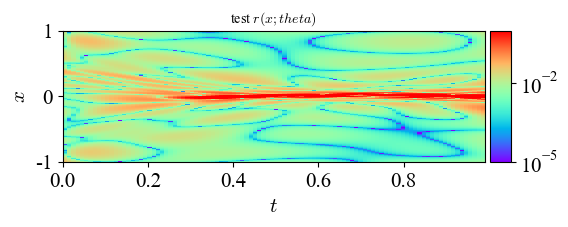

1000 tensor(0.0114, grad_fn=<AddBackward0>)
2000 tensor(0.0047, grad_fn=<AddBackward0>)
3000 tensor(0.0028, grad_fn=<AddBackward0>)
4000 tensor(0.0021, grad_fn=<AddBackward0>)
5000 tensor(0.0020, grad_fn=<AddBackward0>)
6000 tensor(0.0015, grad_fn=<AddBackward0>)
7000 tensor(0.0014, grad_fn=<AddBackward0>)
8000 tensor(0.0012, grad_fn=<AddBackward0>)
9000 tensor(0.0010, grad_fn=<AddBackward0>)
10000 tensor(0.0009, grad_fn=<AddBackward0>)
11000 tensor(0.0008, grad_fn=<AddBackward0>)
12000 tensor(0.0007, grad_fn=<AddBackward0>)
13000 tensor(0.0007, grad_fn=<AddBackward0>)
14000 tensor(0.0006, grad_fn=<AddBackward0>)
15000 tensor(0.0005, grad_fn=<AddBackward0>)
16000 tensor(0.0005, grad_fn=<AddBackward0>)
17000 tensor(0.0004, grad_fn=<AddBackward0>)
18000 tensor(0.0004, grad_fn=<AddBackward0>)
19000 tensor(0.0009, grad_fn=<AddBackward0>)
20000 tensor(0.0005, grad_fn=<AddBackward0>)
21000 tensor(0.0003, grad_fn=<AddBackward0>)
22000 tensor(0.0004, grad_fn=<AddBackward0>)
23000 tensor(0.0003

175000 tensor(3.3367e-05, grad_fn=<AddBackward0>)
176000 tensor(2.9421e-05, grad_fn=<AddBackward0>)
177000 tensor(2.9364e-05, grad_fn=<AddBackward0>)
178000 tensor(3.2430e-05, grad_fn=<AddBackward0>)
179000 tensor(3.2138e-05, grad_fn=<AddBackward0>)
180000 tensor(2.8499e-05, grad_fn=<AddBackward0>)
181000 tensor(2.8893e-05, grad_fn=<AddBackward0>)
182000 tensor(2.8404e-05, grad_fn=<AddBackward0>)
183000 tensor(2.8568e-05, grad_fn=<AddBackward0>)
184000 tensor(2.7643e-05, grad_fn=<AddBackward0>)
185000 tensor(0.0001, grad_fn=<AddBackward0>)
186000 tensor(6.0580e-05, grad_fn=<AddBackward0>)
187000 tensor(2.7146e-05, grad_fn=<AddBackward0>)
188000 tensor(4.1133e-05, grad_fn=<AddBackward0>)
189000 tensor(2.6588e-05, grad_fn=<AddBackward0>)
190000 tensor(2.7064e-05, grad_fn=<AddBackward0>)
191000 tensor(6.5925e-05, grad_fn=<AddBackward0>)
192000 tensor(4.1636e-05, grad_fn=<AddBackward0>)
193000 tensor(3.3621e-05, grad_fn=<AddBackward0>)
194000 tensor(2.5592e-05, grad_fn=<AddBackward0>)
1950

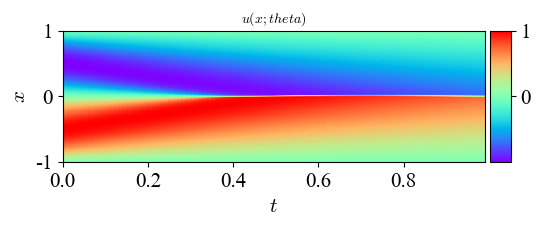

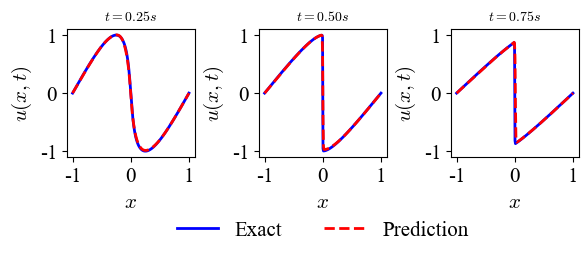

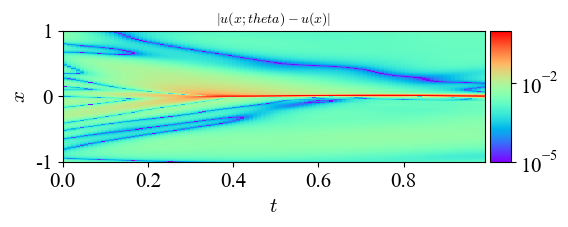

In [4]:
''' k=1 '''
x_adv = generate_attack_samples(PINN, device, x_train, N0, n_samples=500)
retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt, epoch=2e5)

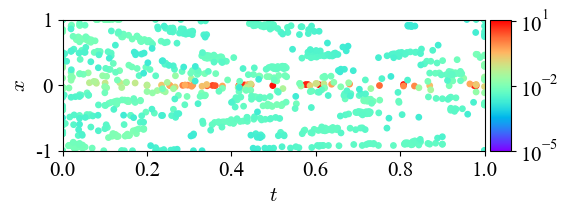

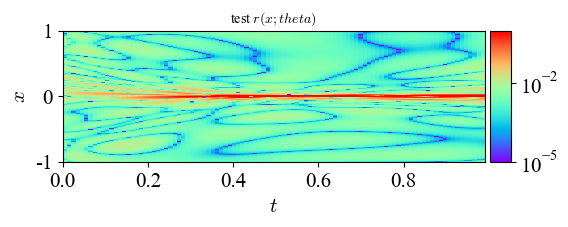

1000 tensor(0.0031, grad_fn=<AddBackward0>)
2000 tensor(0.0017, grad_fn=<AddBackward0>)
3000 tensor(0.0012, grad_fn=<AddBackward0>)
4000 tensor(0.0009, grad_fn=<AddBackward0>)
5000 tensor(0.0007, grad_fn=<AddBackward0>)
6000 tensor(0.0005, grad_fn=<AddBackward0>)
7000 tensor(0.0004, grad_fn=<AddBackward0>)
8000 tensor(0.0003, grad_fn=<AddBackward0>)
9000 tensor(0.0004, grad_fn=<AddBackward0>)
10000 tensor(0.0003, grad_fn=<AddBackward0>)
11000 tensor(0.0003, grad_fn=<AddBackward0>)
12000 tensor(0.0002, grad_fn=<AddBackward0>)
13000 tensor(0.0002, grad_fn=<AddBackward0>)
14000 tensor(0.0002, grad_fn=<AddBackward0>)
15000 tensor(0.0002, grad_fn=<AddBackward0>)
16000 tensor(0.0002, grad_fn=<AddBackward0>)
17000 tensor(0.0004, grad_fn=<AddBackward0>)
18000 tensor(0.0002, grad_fn=<AddBackward0>)
19000 tensor(0.0001, grad_fn=<AddBackward0>)
20000 tensor(0.0001, grad_fn=<AddBackward0>)
21000 tensor(0.0001, grad_fn=<AddBackward0>)
22000 tensor(0.0001, grad_fn=<AddBackward0>)
23000 tensor(0.0002

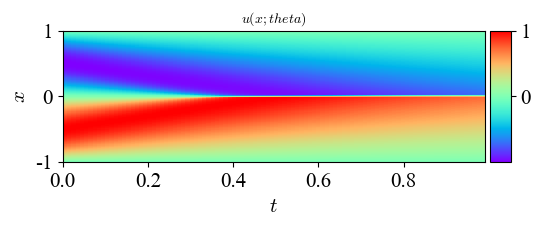

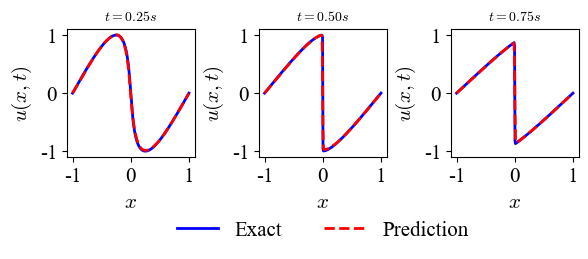

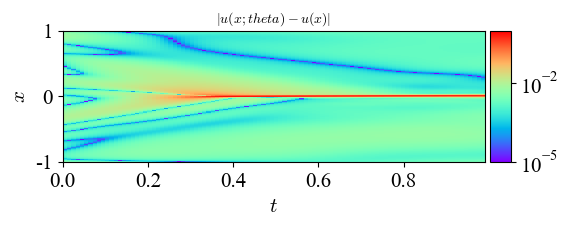

In [5]:
''' k=2 '''
x_train = np.vstack([x_train, x_adv])
x_adv = generate_attack_samples(PINN, device, x_train, N0)
retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)

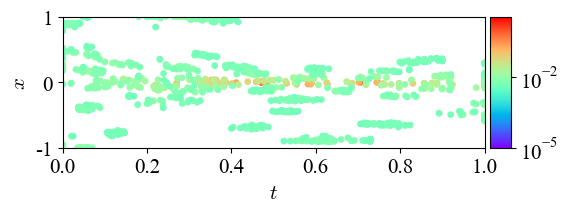

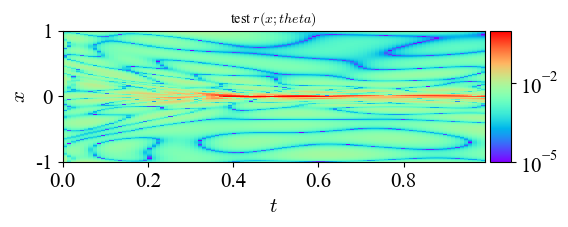

1000 tensor(0.0002, grad_fn=<AddBackward0>)
2000 tensor(0.0001, grad_fn=<AddBackward0>)
3000 tensor(0.0001, grad_fn=<AddBackward0>)
4000 tensor(0.0001, grad_fn=<AddBackward0>)
5000 tensor(9.7330e-05, grad_fn=<AddBackward0>)
6000 tensor(8.9056e-05, grad_fn=<AddBackward0>)
7000 tensor(8.6219e-05, grad_fn=<AddBackward0>)
8000 tensor(8.0312e-05, grad_fn=<AddBackward0>)
9000 tensor(7.7391e-05, grad_fn=<AddBackward0>)
10000 tensor(7.4202e-05, grad_fn=<AddBackward0>)
11000 tensor(7.1741e-05, grad_fn=<AddBackward0>)
12000 tensor(6.9649e-05, grad_fn=<AddBackward0>)
13000 tensor(0.0001, grad_fn=<AddBackward0>)
14000 tensor(6.6611e-05, grad_fn=<AddBackward0>)
15000 tensor(6.5012e-05, grad_fn=<AddBackward0>)
16000 tensor(6.5320e-05, grad_fn=<AddBackward0>)
17000 tensor(8.9001e-05, grad_fn=<AddBackward0>)
18000 tensor(6.0526e-05, grad_fn=<AddBackward0>)
19000 tensor(5.9128e-05, grad_fn=<AddBackward0>)
20000 tensor(5.7999e-05, grad_fn=<AddBackward0>)
21000 tensor(5.6962e-05, grad_fn=<AddBackward0>)


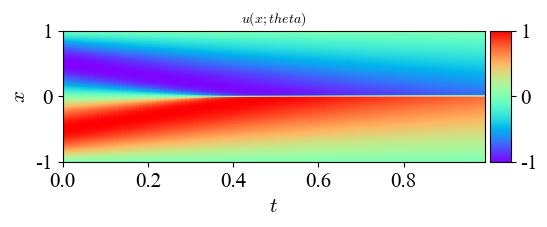

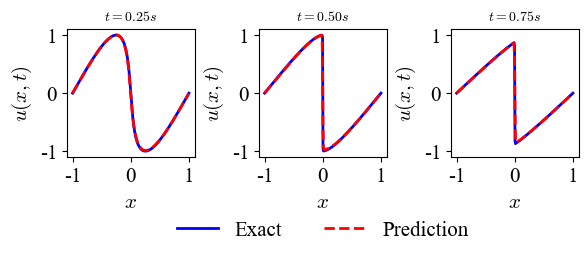

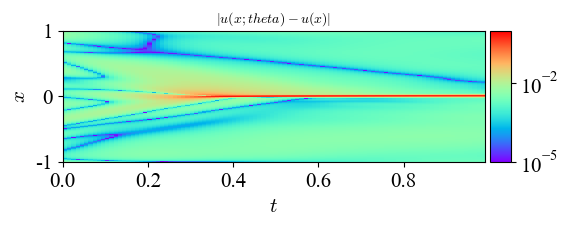

In [6]:
''' k=3 '''
x_train = np.vstack([x_train, x_adv])
x_adv = generate_attack_samples(PINN, device, x_train, N0)
retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, u_test, U_gt)